# Sphere Generative Adversarial Network Based on Geometric Moment Matching

## CENG796 Deep Generative Models Class Project 

Ismail Hakki Kocdemir 2036051, 
Hazan Anayurt 2098747

For this project, we tried to implement the following CVPR 2019 paper:

http://openaccess.thecvf.com/content_CVPR_2019/papers/Park_Sphere_Generative_Adversarial_Network_Based_on_Geometric_Moment_Matching_CVPR_2019_paper.pdf

### Assumptions

We made the following assumptions for the details that we could not infer from the paper:

1. We assumed that Inverse Stereographic projection is done by using a plane that goes trough the center of the sphere rahter than a tangent one that is below the sphere, which we inferred from their equations. This was other way around we we look at just the figures. 

2. We assumed that they did not use bias for Conv. layers.

3. For the formulation of Inverse Stereographic projection, we used the one in the paper and ignored the supplementary material, as it seemed erroneous. 

### Difficulties encountered 

First of all we could not achieve the scores mentioned in the paper. We believe that our implementation of the architectures and the proposed Geometric Block faitfully follows what is provided in the paper. However, our results were significantly inferior to the reported ones. We could not spot any specific problem, but our results were not as meaningful, both qualitatively and qunatitatively. 

In the training process ConvNet architecture, the model seems to be generating promising images in the beggining. Later on, it stops improving and gets stuck at a point where it gets IS score around 2-2.5. The best model achieves 4.0. 

For the Resnet, it also seems promising in the beggining but suddenly starts to procude single colour images after some point. The best model achieved 4.93 IS score.

The things we tried that did not work, on top of what is already provided in the paper:

1. Adding bias into the Conv. layers.
2. Adding BatchNorm layer after the first dense layers in the Generators.
3. Using a learning rate scheduler, which gradually decreases the learning rate. We used this for preventing sudden degradations in the performance we experienced.
4. Adding weight decay.


The rest of the notebook consists of hyperparameter setup, model constructions and training in the order of SphereGAN-Convnet followed by SphereGAN-Resnet. One can find the training procedure results and IS and FID scores in the ouput cells.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision.transforms as transforms
from torchvision.models.inception import inception_v3

import numpy as np

#from convnet import DiscriminatorConvNet, GeneratorConvNet
#from resnet import DiscriminatorResNet, GeneratorResNet
from utils import *
from model_utils import *


# Hyperparameters

Taken exactly from the paper.

In [7]:
num_gpu = 1
lr = 1e-4
beta1 = 0
beta2 = 0.9
num_epochs = 1300

dataroot="./data"
batch_size = 64
workers = 4
image_size= 48

real_label = 1
fake_label = -1

# Look for available GPU(s)
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

inception_net = load_model("./data/inception_v3.pt").cpu()

fixed_noise = torch.randn(64, 128, device="cpu")

# Sphere-GAN CONVNET Training

In [4]:
manual_seed = 333
random.seed(manual_seed)

torch.manual_seed(manual_seed)
genConv = GeneratorConvNet().to(device)

torch.manual_seed(manual_seed)
disConv = DiscriminatorConvNet().to(device)

torch.manual_seed(manual_seed)
genConv.apply(weights_init)
torch.manual_seed(manual_seed)
disConv.apply(weights_init)


DiscriminatorConvNet(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (ln1_1): LayerNorm(torch.Size([64, 48, 48]), eps=1e-05, elementwise_affine=True)
  (lrelu1_1): LeakyReLU(negative_slope=0.2, inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (ln1_2): LayerNorm(torch.Size([64, 24, 24]), eps=1e-05, elementwise_affine=True)
  (lrelu1_2): LeakyReLU(negative_slope=0.2, inplace)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (ln2_1): LayerNorm(torch.Size([128, 24, 24]), eps=1e-05, elementwise_affine=True)
  (lrelu2_1): LeakyReLU(negative_slope=0.2, inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (ln2_2): LayerNorm(torch.Size([128, 12, 12]), eps=1e-05, elementwise_affine=True)
  (lrelu2_2): LeakyReLU(negative_slope=0.2, inplace)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

In [5]:
optimizerG = optim.Adam(genConv.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = optim.Adam(disConv.parameters(), lr=lr, betas=(beta1, beta2))

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator

dataloader = get_stl10_dataloader(dataroot, batch_size, workers, image_size)
criterion = nn.BCELoss()

best_is = [0,0]

img_list = []
G_losses = []
D_losses = []
iters = 0
moments = 5

Files already downloaded and verified


In [6]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update Discriminator
        ###########################
        disConv.zero_grad()
        label = torch.full((batch_size, 1), real_label, device=device)
        
        # Forward pass real batch through D
        output = disConv(data[0].to(device))
        
        # Calculate loss on all-real batch
        error_disc_real = total_moment_distance(output, label, moments, device) # criterion(output, label) #
        
        # Calculate gradients for D in backward pass
        error_disc_real.backward()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, 128, device=device)
        
        # Generate fake image batch with G
        fake = genConv(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = disConv(fake.detach())
        
        # Calculate D's loss on the all-fake batch
        error_disc_fake = total_moment_distance(output, label, moments, device) # criterion(output, label) #
        
        # Calculate the gradients for this batch
        error_disc_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        error_disc = error_disc_real + error_disc_fake
        #error_disc.backward()
        
        # Update D
        optimizerD.step()

        ############################
        # (2) Update Generator
        ###########################
        genConv.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disConv(fake)
        
        # Calculate G's loss based on this output
        error_gen = total_moment_distance(output, label, moments, device) # criterion(output, label)
        
        # Calculate gradients for G
        error_gen.backward()
        
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     error_disc.item(), error_gen.item()))

        # Save Losses for plotting later
        G_losses.append(error_gen.item())
        D_losses.append(error_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_images = genConv(fixed_noise.to(device)).detach().cpu()
            img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
            
            genConv = genConv.cpu()
            disConv = disConv.cpu()
            inception_net = inception_net.to(device)
   
            _is = inception_score_val(fake_images, inception_net, device)
            print("Iter:", iters,  "Inception Score:", _is, "\n")
            if (_is[0] > 2.0 and best_is[0] == 0) or (_is[0] > best_is[0] and best_is[0] != 0):
                best_is = _is
                torch.save({
                    'epoch': epoch,
                    'gen_state_dict': genConv.state_dict(),
                    'gen_optimizer_state_dict': optimizerG.state_dict(),
                    'dis_state_dict': disConv.state_dict(),
                    'dis_optimizer_state_dict': optimizerD.state_dict(),
                    'img_list': img_list,
                    'inception_score': best_is
                    }, './checkpoints/convnet_state_dict_{}'.format(epoch))
                
                save_model(genConv, "./best_models_convnet/model_{}.pt".format(epoch))

            inception_net = inception_net.cpu()
            genConv = genConv.to(device)
            disConv = disConv.to(device)
            
            plt.clf()
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list[-1],(1,2,0)))
            plt.savefig("./figures/progress/convnet_fake_iter_{}.svg".format(iters))
            plt.clf()

        iters += 1

[0/1300][0/78]	Loss_D: 0.0001	Loss_G: 0.0113
Iter: 0 Inception Score: (1.0438094548141235, 0.009652942390166341) 

[0/1300][50/78]	Loss_D: -0.0296	Loss_G: 0.0486
[1/1300][0/78]	Loss_D: -0.1491	Loss_G: 0.0932
[1/1300][50/78]	Loss_D: -0.0870	Loss_G: 0.1267
[2/1300][0/78]	Loss_D: -0.0532	Loss_G: 0.0759
[2/1300][50/78]	Loss_D: -0.1725	Loss_G: 0.4046
[3/1300][0/78]	Loss_D: -0.4421	Loss_G: 0.0409
[3/1300][50/78]	Loss_D: -0.0855	Loss_G: 0.1052
[4/1300][0/78]	Loss_D: -0.1215	Loss_G: 0.1767
[4/1300][50/78]	Loss_D: -0.3470	Loss_G: 0.0965
[5/1300][0/78]	Loss_D: -0.1261	Loss_G: 0.1744
[5/1300][50/78]	Loss_D: -0.0656	Loss_G: 0.0773
[6/1300][0/78]	Loss_D: -0.0948	Loss_G: 0.1152
Iter: 500 Inception Score: (1.0381741970290448, 0.014850462897308798) 

[6/1300][50/78]	Loss_D: -0.0657	Loss_G: 0.0746
[7/1300][0/78]	Loss_D: -0.2505	Loss_G: 0.4753
[7/1300][50/78]	Loss_D: -0.0964	Loss_G: 0.1128
[8/1300][0/78]	Loss_D: -0.1508	Loss_G: 0.2113
[8/1300][50/78]	Loss_D: -0.1801	Loss_G: 0.2245
[9/1300][0/78]	Loss_D:

[77/1300][0/78]	Loss_D: -0.1944	Loss_G: 0.2963
[77/1300][50/78]	Loss_D: -0.1451	Loss_G: 0.1867
[78/1300][0/78]	Loss_D: -0.0080	Loss_G: 0.1813
[78/1300][50/78]	Loss_D: -0.4533	Loss_G: 0.6125
[79/1300][0/78]	Loss_D: -3.0880	Loss_G: 0.2010
[79/1300][50/78]	Loss_D: -0.9602	Loss_G: 4.6188
[80/1300][0/78]	Loss_D: -0.3106	Loss_G: 0.5003
[80/1300][50/78]	Loss_D: -0.5053	Loss_G: 0.7898
[81/1300][0/78]	Loss_D: -0.2853	Loss_G: 0.4904
[81/1300][50/78]	Loss_D: -1.5616	Loss_G: 6.1168
[82/1300][0/78]	Loss_D: -0.6937	Loss_G: 0.7413
[82/1300][50/78]	Loss_D: -0.4534	Loss_G: 0.4857
[83/1300][0/78]	Loss_D: -3.8655	Loss_G: 18.1048
Iter: 6500 Inception Score: (1.3492571473779265, 0.09864019444544511) 

[83/1300][50/78]	Loss_D: -0.2372	Loss_G: 0.4112
[84/1300][0/78]	Loss_D: -0.9088	Loss_G: 7.9209
[84/1300][50/78]	Loss_D: -0.0291	Loss_G: 0.4682
[85/1300][0/78]	Loss_D: 0.1018	Loss_G: 0.1006
[85/1300][50/78]	Loss_D: -0.0003	Loss_G: 0.0624
[86/1300][0/78]	Loss_D: 0.0322	Loss_G: 0.0311
[86/1300][50/78]	Loss_D: -0

Iter: 12000 Inception Score: (1.7053025929474281, 0.14660161509374672) 

[154/1300][0/78]	Loss_D: 0.3627	Loss_G: 0.3135
[154/1300][50/78]	Loss_D: 0.0501	Loss_G: 0.0743
[155/1300][0/78]	Loss_D: -0.0213	Loss_G: 0.1417
[155/1300][50/78]	Loss_D: -2.4705	Loss_G: 7.6038
[156/1300][0/78]	Loss_D: -48.7594	Loss_G: 29.4754
[156/1300][50/78]	Loss_D: -2.9477	Loss_G: 11.2012
[157/1300][0/78]	Loss_D: -32.0024	Loss_G: 149.3878
[157/1300][50/78]	Loss_D: -23.9232	Loss_G: 165.9871
[158/1300][0/78]	Loss_D: -11.2096	Loss_G: 55.0494
[158/1300][50/78]	Loss_D: -22.2698	Loss_G: 99.4315
[159/1300][0/78]	Loss_D: -49.9487	Loss_G: 143.3809
[159/1300][50/78]	Loss_D: -38.9413	Loss_G: 84.8819
[160/1300][0/78]	Loss_D: -94.2561	Loss_G: 7.5983
Iter: 12500 Inception Score: (1.7965016024938731, 0.25734851700820327) 

[160/1300][50/78]	Loss_D: -17.1264	Loss_G: 115.6331
[161/1300][0/78]	Loss_D: -5.3763	Loss_G: 18.5501
[161/1300][50/78]	Loss_D: -91.0960	Loss_G: 12.7362
[162/1300][0/78]	Loss_D: -11.3267	Loss_G: 120.2048
[162

[226/1300][0/78]	Loss_D: -81.1581	Loss_G: 175.2645
[226/1300][50/78]	Loss_D: -92.1668	Loss_G: 193.7477
[227/1300][0/78]	Loss_D: -18.3067	Loss_G: 97.6572
[227/1300][50/78]	Loss_D: -35.0016	Loss_G: 236.7427
[228/1300][0/78]	Loss_D: -30.9962	Loss_G: 189.4745
[228/1300][50/78]	Loss_D: -24.9120	Loss_G: 236.4891
[229/1300][0/78]	Loss_D: -31.4257	Loss_G: 216.5505
[229/1300][50/78]	Loss_D: -23.2638	Loss_G: 78.8434
[230/1300][0/78]	Loss_D: -85.9031	Loss_G: 202.1971
[230/1300][50/78]	Loss_D: -29.3451	Loss_G: 219.5526
Iter: 18000 Inception Score: (1.698085502583935, 0.12288340222562992) 

[231/1300][0/78]	Loss_D: -95.7239	Loss_G: 197.7162
[231/1300][50/78]	Loss_D: -52.1234	Loss_G: 219.4868
[232/1300][0/78]	Loss_D: -41.9501	Loss_G: 203.4791
[232/1300][50/78]	Loss_D: -43.5061	Loss_G: 253.4044
[233/1300][0/78]	Loss_D: -110.3979	Loss_G: 172.5780
[233/1300][50/78]	Loss_D: -95.3887	Loss_G: 166.1442
[234/1300][0/78]	Loss_D: -78.8994	Loss_G: 183.6499
[234/1300][50/78]	Loss_D: -113.7813	Loss_G: 135.3677
[

[297/1300][50/78]	Loss_D: -94.7534	Loss_G: 309.7634
[298/1300][0/78]	Loss_D: -170.7072	Loss_G: 190.1915
[298/1300][50/78]	Loss_D: -127.1824	Loss_G: 260.9721
[299/1300][0/78]	Loss_D: -149.3918	Loss_G: 142.1641
[299/1300][50/78]	Loss_D: -113.4086	Loss_G: 154.8422
[300/1300][0/78]	Loss_D: -147.4370	Loss_G: 108.2357
[300/1300][50/78]	Loss_D: -45.5881	Loss_G: 172.2731
[301/1300][0/78]	Loss_D: -81.6898	Loss_G: 247.5599
Iter: 23500 Inception Score: (1.5883622786241043, 0.1351719471360754) 

[301/1300][50/78]	Loss_D: -157.4002	Loss_G: 162.4712
[302/1300][0/78]	Loss_D: -178.7699	Loss_G: 195.2925
[302/1300][50/78]	Loss_D: -80.4103	Loss_G: 336.0373
[303/1300][0/78]	Loss_D: -100.0785	Loss_G: 270.6191
[303/1300][50/78]	Loss_D: -93.0765	Loss_G: 338.6456
[304/1300][0/78]	Loss_D: -99.8772	Loss_G: 334.5514
[304/1300][50/78]	Loss_D: -152.9429	Loss_G: 228.5894
[305/1300][0/78]	Loss_D: -173.0656	Loss_G: 124.0756
[305/1300][50/78]	Loss_D: -173.8900	Loss_G: 213.0537
[306/1300][0/78]	Loss_D: -144.3387	Loss_G

[368/1300][50/78]	Loss_D: -138.4932	Loss_G: 323.5014
[369/1300][0/78]	Loss_D: -88.5099	Loss_G: 348.5942
[369/1300][50/78]	Loss_D: -183.7619	Loss_G: 161.9788
[370/1300][0/78]	Loss_D: -175.8183	Loss_G: 271.6570
[370/1300][50/78]	Loss_D: -172.7845	Loss_G: 230.8427
[371/1300][0/78]	Loss_D: -154.5706	Loss_G: 138.5234
[371/1300][50/78]	Loss_D: -126.5240	Loss_G: 218.6744
Iter: 29000 Inception Score: (1.7033089247986148, 0.143594915334775) 

[372/1300][0/78]	Loss_D: -186.4014	Loss_G: 233.6672
[372/1300][50/78]	Loss_D: -141.6063	Loss_G: 359.3586
[373/1300][0/78]	Loss_D: -134.0809	Loss_G: 298.9318
[373/1300][50/78]	Loss_D: -239.7051	Loss_G: 192.7065
[374/1300][0/78]	Loss_D: -175.0388	Loss_G: 281.3755
[374/1300][50/78]	Loss_D: -139.3454	Loss_G: 359.6746
[375/1300][0/78]	Loss_D: -149.4067	Loss_G: 344.8593
[375/1300][50/78]	Loss_D: -122.9400	Loss_G: 339.3326
[376/1300][0/78]	Loss_D: -212.3166	Loss_G: 148.0804
[376/1300][50/78]	Loss_D: -133.5407	Loss_G: 330.1696
[377/1300][0/78]	Loss_D: -137.5312	Lo

[439/1300][0/78]	Loss_D: -246.8836	Loss_G: 206.6538
[439/1300][50/78]	Loss_D: -237.2453	Loss_G: 258.2554
[440/1300][0/78]	Loss_D: -185.8055	Loss_G: 345.1246
[440/1300][50/78]	Loss_D: -173.0388	Loss_G: 389.9461
[441/1300][0/78]	Loss_D: -178.1122	Loss_G: 353.8135
[441/1300][50/78]	Loss_D: -245.1535	Loss_G: 242.8303
[442/1300][0/78]	Loss_D: -300.9758	Loss_G: 306.5408
Iter: 34500 Inception Score: (1.8416657843518316, 0.1371441046643471) 

[442/1300][50/78]	Loss_D: -143.0943	Loss_G: 377.5799
[443/1300][0/78]	Loss_D: -290.8772	Loss_G: 241.7191
[443/1300][50/78]	Loss_D: -194.3383	Loss_G: 365.3047
[444/1300][0/78]	Loss_D: -318.9466	Loss_G: 277.7693
[444/1300][50/78]	Loss_D: -264.9900	Loss_G: 245.4151
[445/1300][0/78]	Loss_D: -237.1666	Loss_G: 243.0011
[445/1300][50/78]	Loss_D: -200.2303	Loss_G: 374.1225
[446/1300][0/78]	Loss_D: -209.3230	Loss_G: 258.2160
[446/1300][50/78]	Loss_D: -212.0585	Loss_G: 325.0956
[447/1300][0/78]	Loss_D: -218.1325	Loss_G: 237.0518
[447/1300][50/78]	Loss_D: -159.4223	

[509/1300][50/78]	Loss_D: -245.8331	Loss_G: 358.8035
[510/1300][0/78]	Loss_D: -179.8438	Loss_G: 376.7426
[510/1300][50/78]	Loss_D: -248.4712	Loss_G: 374.9670
[511/1300][0/78]	Loss_D: -270.1618	Loss_G: 356.9115
[511/1300][50/78]	Loss_D: -298.7930	Loss_G: 297.9596
[512/1300][0/78]	Loss_D: -240.5264	Loss_G: 276.5609
[512/1300][50/78]	Loss_D: -286.9071	Loss_G: 289.2888
Iter: 40000 Inception Score: (1.8905320984275509, 0.32739542137174193) 

[513/1300][0/78]	Loss_D: -245.3802	Loss_G: 286.7853
[513/1300][50/78]	Loss_D: -242.6462	Loss_G: 313.8898
[514/1300][0/78]	Loss_D: -269.2019	Loss_G: 273.3271
[514/1300][50/78]	Loss_D: -220.0696	Loss_G: 376.7672
[515/1300][0/78]	Loss_D: -279.3214	Loss_G: 338.0207
[515/1300][50/78]	Loss_D: -181.6435	Loss_G: 377.3653
[516/1300][0/78]	Loss_D: -254.3479	Loss_G: 345.5199
[516/1300][50/78]	Loss_D: -247.5247	Loss_G: 389.7610
[517/1300][0/78]	Loss_D: -181.2519	Loss_G: 341.8560
[517/1300][50/78]	Loss_D: -173.5739	Loss_G: 345.8592
[518/1300][0/78]	Loss_D: -280.3235

[580/1300][0/78]	Loss_D: -308.4922	Loss_G: 334.9348
[580/1300][50/78]	Loss_D: -269.8430	Loss_G: 305.2757
[581/1300][0/78]	Loss_D: -306.1705	Loss_G: 311.2206
[581/1300][50/78]	Loss_D: -265.1093	Loss_G: 384.7807
[582/1300][0/78]	Loss_D: -303.3282	Loss_G: 315.2124
[582/1300][50/78]	Loss_D: -299.9300	Loss_G: 333.3919
[583/1300][0/78]	Loss_D: -303.8335	Loss_G: 304.6729
Iter: 45500 Inception Score: (1.8796567542457912, 0.24146523114467786) 

[583/1300][50/78]	Loss_D: -303.2685	Loss_G: 382.2815
[584/1300][0/78]	Loss_D: -228.5783	Loss_G: 403.3607
[584/1300][50/78]	Loss_D: -234.5002	Loss_G: 395.7145
[585/1300][0/78]	Loss_D: -269.7449	Loss_G: 238.6801
[585/1300][50/78]	Loss_D: -311.2745	Loss_G: 375.7859
[586/1300][0/78]	Loss_D: -219.7959	Loss_G: 401.0517
[586/1300][50/78]	Loss_D: -268.5876	Loss_G: 385.1880
[587/1300][0/78]	Loss_D: -318.8404	Loss_G: 331.5771
[587/1300][50/78]	Loss_D: -320.0978	Loss_G: 357.8071
[588/1300][0/78]	Loss_D: -304.7506	Loss_G: 383.6161
[588/1300][50/78]	Loss_D: -294.2151

[651/1300][0/78]	Loss_D: -345.9334	Loss_G: 378.9478
[651/1300][50/78]	Loss_D: -324.5206	Loss_G: 338.3193
[652/1300][0/78]	Loss_D: -327.9139	Loss_G: 332.6286
[652/1300][50/78]	Loss_D: -353.8019	Loss_G: 382.7797
[653/1300][0/78]	Loss_D: -284.1067	Loss_G: 406.3592
[653/1300][50/78]	Loss_D: -303.8877	Loss_G: 319.5049
Iter: 51000 Inception Score: (1.9564162315908267, 0.28105343110985354) 

[654/1300][0/78]	Loss_D: -315.4545	Loss_G: 400.2117
[654/1300][50/78]	Loss_D: -321.3120	Loss_G: 340.8369
[655/1300][0/78]	Loss_D: -317.3123	Loss_G: 294.1411
[655/1300][50/78]	Loss_D: -302.7745	Loss_G: 402.0305
[656/1300][0/78]	Loss_D: -279.3683	Loss_G: 388.8494
[656/1300][50/78]	Loss_D: -289.4095	Loss_G: 308.6600
[657/1300][0/78]	Loss_D: -307.2976	Loss_G: 336.8062
[657/1300][50/78]	Loss_D: -329.8090	Loss_G: 319.2134
[658/1300][0/78]	Loss_D: -293.7004	Loss_G: 406.8879
[658/1300][50/78]	Loss_D: -346.1306	Loss_G: 348.3104
[659/1300][0/78]	Loss_D: -286.7087	Loss_G: 409.8131
[659/1300][50/78]	Loss_D: -340.3461

[721/1300][50/78]	Loss_D: -339.2659	Loss_G: 382.1299
[722/1300][0/78]	Loss_D: -334.7242	Loss_G: 404.8728
[722/1300][50/78]	Loss_D: -310.2430	Loss_G: 404.2346
[723/1300][0/78]	Loss_D: -324.4597	Loss_G: 402.9450
[723/1300][50/78]	Loss_D: -332.8732	Loss_G: 334.5120
[724/1300][0/78]	Loss_D: -229.6546	Loss_G: 386.5731
Iter: 56500 Inception Score: (2.0069485170572117, 0.2123577603344918) 

[724/1300][50/78]	Loss_D: -347.6097	Loss_G: 351.8762
[725/1300][0/78]	Loss_D: -356.3947	Loss_G: 322.5131
[725/1300][50/78]	Loss_D: -332.0540	Loss_G: 393.5102
[726/1300][0/78]	Loss_D: -345.0266	Loss_G: 395.4494
[726/1300][50/78]	Loss_D: -378.2960	Loss_G: 373.1198
[727/1300][0/78]	Loss_D: -327.2473	Loss_G: 399.1560
[727/1300][50/78]	Loss_D: -294.2301	Loss_G: 395.1779
[728/1300][0/78]	Loss_D: -371.6887	Loss_G: 343.8358
[728/1300][50/78]	Loss_D: -347.2582	Loss_G: 294.6262
[729/1300][0/78]	Loss_D: -334.8861	Loss_G: 407.9773
[729/1300][50/78]	Loss_D: -374.1987	Loss_G: 385.0907
[730/1300][0/78]	Loss_D: -385.3645	

[792/1300][0/78]	Loss_D: -371.4767	Loss_G: 368.7831
[792/1300][50/78]	Loss_D: -254.4883	Loss_G: 416.7599
[793/1300][0/78]	Loss_D: -347.7458	Loss_G: 398.5131
[793/1300][50/78]	Loss_D: -335.6584	Loss_G: 352.5555
[794/1300][0/78]	Loss_D: -329.4001	Loss_G: 335.5829
[794/1300][50/78]	Loss_D: -352.9789	Loss_G: 411.8211
Iter: 62000 Inception Score: (2.1116956149493484, 0.24752610044204434) 

[795/1300][0/78]	Loss_D: -346.5378	Loss_G: 420.8394
[795/1300][50/78]	Loss_D: -350.0349	Loss_G: 410.6104
[796/1300][0/78]	Loss_D: -341.8495	Loss_G: 352.7424
[796/1300][50/78]	Loss_D: -261.8506	Loss_G: 413.7287
[797/1300][0/78]	Loss_D: -328.1758	Loss_G: 331.5822
[797/1300][50/78]	Loss_D: -350.5370	Loss_G: 380.1830
[798/1300][0/78]	Loss_D: -335.7194	Loss_G: 380.3060
[798/1300][50/78]	Loss_D: -362.7116	Loss_G: 386.2336
[799/1300][0/78]	Loss_D: -364.0288	Loss_G: 380.6947
[799/1300][50/78]	Loss_D: -341.3356	Loss_G: 406.3936
[800/1300][0/78]	Loss_D: -347.1586	Loss_G: 388.3823
[800/1300][50/78]	Loss_D: -328.3823

[862/1300][50/78]	Loss_D: -361.4923	Loss_G: 343.4708
[863/1300][0/78]	Loss_D: -361.1045	Loss_G: 402.1609
[863/1300][50/78]	Loss_D: -364.6533	Loss_G: 340.9524
[864/1300][0/78]	Loss_D: -333.0547	Loss_G: 408.2668
[864/1300][50/78]	Loss_D: -231.6592	Loss_G: 404.0629
[865/1300][0/78]	Loss_D: -365.1260	Loss_G: 375.4847
Iter: 67500 Inception Score: (2.1219192287934368, 0.3511874762811629) 

[865/1300][50/78]	Loss_D: -346.1804	Loss_G: 420.2343
[866/1300][0/78]	Loss_D: -370.1287	Loss_G: 398.6776
[866/1300][50/78]	Loss_D: -344.5598	Loss_G: 368.8996
[867/1300][0/78]	Loss_D: -385.1263	Loss_G: 394.3787
[867/1300][50/78]	Loss_D: -366.2297	Loss_G: 304.7076
[868/1300][0/78]	Loss_D: -359.6880	Loss_G: 391.3310
[868/1300][50/78]	Loss_D: -375.9617	Loss_G: 404.9989
[869/1300][0/78]	Loss_D: -364.8011	Loss_G: 369.3333
[869/1300][50/78]	Loss_D: -386.9851	Loss_G: 391.0763
[870/1300][0/78]	Loss_D: -327.5963	Loss_G: 423.1200
[870/1300][50/78]	Loss_D: -369.5180	Loss_G: 388.5428
[871/1300][0/78]	Loss_D: -383.9088	

[933/1300][0/78]	Loss_D: -383.8785	Loss_G: 389.9624
[933/1300][50/78]	Loss_D: -366.6153	Loss_G: 418.7047
[934/1300][0/78]	Loss_D: -338.0528	Loss_G: 428.4597
[934/1300][50/78]	Loss_D: -360.0544	Loss_G: 415.3880
[935/1300][0/78]	Loss_D: -403.1849	Loss_G: 399.6875
[935/1300][50/78]	Loss_D: -367.2250	Loss_G: 389.5695
Iter: 73000 Inception Score: (1.9095813587134667, 0.1886087226198966) 

[936/1300][0/78]	Loss_D: -381.6318	Loss_G: 395.5290
[936/1300][50/78]	Loss_D: -376.8474	Loss_G: 400.3057
[937/1300][0/78]	Loss_D: -372.7327	Loss_G: 410.3841
[937/1300][50/78]	Loss_D: -396.2852	Loss_G: 403.7671
[938/1300][0/78]	Loss_D: -394.2024	Loss_G: 403.6102
[938/1300][50/78]	Loss_D: -402.6721	Loss_G: 388.6810
[939/1300][0/78]	Loss_D: -375.2079	Loss_G: 374.0152
[939/1300][50/78]	Loss_D: -365.1888	Loss_G: 400.0712
[940/1300][0/78]	Loss_D: -343.1808	Loss_G: 419.0477
[940/1300][50/78]	Loss_D: -380.9526	Loss_G: 418.6668
[941/1300][0/78]	Loss_D: -393.1303	Loss_G: 410.8096
[941/1300][50/78]	Loss_D: -378.5226	

[1003/1300][50/78]	Loss_D: -394.1543	Loss_G: 365.3637
[1004/1300][0/78]	Loss_D: -389.6446	Loss_G: 414.6548
[1004/1300][50/78]	Loss_D: -385.6754	Loss_G: 401.4746
[1005/1300][0/78]	Loss_D: -326.9544	Loss_G: 346.0235
[1005/1300][50/78]	Loss_D: -394.2500	Loss_G: 393.9453
[1006/1300][0/78]	Loss_D: -347.9417	Loss_G: 358.6052
Iter: 78500 Inception Score: (2.1033528029953468, 0.261712378688841) 

[1006/1300][50/78]	Loss_D: -402.3073	Loss_G: 408.7641
[1007/1300][0/78]	Loss_D: -384.2172	Loss_G: 382.1215
[1007/1300][50/78]	Loss_D: -382.5263	Loss_G: 409.9490
[1008/1300][0/78]	Loss_D: -399.3895	Loss_G: 406.0865
[1008/1300][50/78]	Loss_D: -400.9800	Loss_G: 411.6634
[1009/1300][0/78]	Loss_D: -391.4145	Loss_G: 412.4089
[1009/1300][50/78]	Loss_D: -399.0444	Loss_G: 387.2278
[1010/1300][0/78]	Loss_D: -351.7149	Loss_G: 342.2522
[1010/1300][50/78]	Loss_D: -378.4166	Loss_G: 412.4096
[1011/1300][0/78]	Loss_D: -407.6906	Loss_G: 409.3631
[1011/1300][50/78]	Loss_D: -389.1753	Loss_G: 412.4330
[1012/1300][0/78]	L

[1073/1300][0/78]	Loss_D: -407.8869	Loss_G: 403.9922
[1073/1300][50/78]	Loss_D: -412.2646	Loss_G: 401.6593
[1074/1300][0/78]	Loss_D: -395.3325	Loss_G: 394.0596
[1074/1300][50/78]	Loss_D: -366.5520	Loss_G: 355.4527
[1075/1300][0/78]	Loss_D: -390.4303	Loss_G: 410.0036
[1075/1300][50/78]	Loss_D: -314.6358	Loss_G: 344.7971
[1076/1300][0/78]	Loss_D: -373.0749	Loss_G: 418.0840
[1076/1300][50/78]	Loss_D: -392.7385	Loss_G: 382.7690
Iter: 84000 Inception Score: (1.9062732654623449, 0.3258658370354873) 

[1077/1300][0/78]	Loss_D: -373.6652	Loss_G: 427.7174
[1077/1300][50/78]	Loss_D: -386.4490	Loss_G: 412.3340
[1078/1300][0/78]	Loss_D: -387.1812	Loss_G: 419.7391
[1078/1300][50/78]	Loss_D: -402.3742	Loss_G: 413.4967
[1079/1300][0/78]	Loss_D: -401.4101	Loss_G: 411.6638
[1079/1300][50/78]	Loss_D: -383.9987	Loss_G: 425.6892
[1080/1300][0/78]	Loss_D: -393.1291	Loss_G: 409.6760
[1080/1300][50/78]	Loss_D: -372.4165	Loss_G: 403.6618
[1081/1300][0/78]	Loss_D: -394.8678	Loss_G: 409.8098
[1081/1300][50/78]	

[1142/1300][50/78]	Loss_D: -407.8080	Loss_G: 413.7522
[1143/1300][0/78]	Loss_D: -398.3958	Loss_G: 418.2040
[1143/1300][50/78]	Loss_D: -381.7266	Loss_G: 419.7074
[1144/1300][0/78]	Loss_D: -389.8135	Loss_G: 420.6830
[1144/1300][50/78]	Loss_D: -392.5326	Loss_G: 408.9274
[1145/1300][0/78]	Loss_D: -409.2734	Loss_G: 401.6894
[1145/1300][50/78]	Loss_D: -410.0087	Loss_G: 413.0003
[1146/1300][0/78]	Loss_D: -393.9401	Loss_G: 408.3937
[1146/1300][50/78]	Loss_D: -407.1552	Loss_G: 398.6221
[1147/1300][0/78]	Loss_D: -410.4470	Loss_G: 395.7094
Iter: 89500 Inception Score: (2.2685486548168936, 0.5616567383991791) 

[1147/1300][50/78]	Loss_D: -395.4401	Loss_G: 409.3894
[1148/1300][0/78]	Loss_D: -414.2125	Loss_G: 412.0356
[1148/1300][50/78]	Loss_D: -329.4242	Loss_G: 423.9820
[1149/1300][0/78]	Loss_D: -403.6111	Loss_G: 401.4799
[1149/1300][50/78]	Loss_D: -399.7387	Loss_G: 398.6805
[1150/1300][0/78]	Loss_D: -387.4835	Loss_G: 419.1135
[1150/1300][50/78]	Loss_D: -397.1501	Loss_G: 405.0880
[1151/1300][0/78]	

[1212/1300][0/78]	Loss_D: -390.0969	Loss_G: 423.9729
[1212/1300][50/78]	Loss_D: -405.5911	Loss_G: 420.3591
[1213/1300][0/78]	Loss_D: -407.5049	Loss_G: 420.9543
[1213/1300][50/78]	Loss_D: -393.5479	Loss_G: 424.9356
[1214/1300][0/78]	Loss_D: -389.1103	Loss_G: 410.2869
[1214/1300][50/78]	Loss_D: -403.4726	Loss_G: 416.4626
[1215/1300][0/78]	Loss_D: -373.3715	Loss_G: 413.2916
[1215/1300][50/78]	Loss_D: -400.6586	Loss_G: 407.7041
[1216/1300][0/78]	Loss_D: -406.0096	Loss_G: 401.1220
[1216/1300][50/78]	Loss_D: -414.9753	Loss_G: 412.0493
[1217/1300][0/78]	Loss_D: -400.2376	Loss_G: 419.6676
[1217/1300][50/78]	Loss_D: -403.2669	Loss_G: 422.3830
Iter: 95000 Inception Score: (2.0898709076913193, 0.27143260914623546) 

[1218/1300][0/78]	Loss_D: -380.4013	Loss_G: 430.7890
[1218/1300][50/78]	Loss_D: -398.4557	Loss_G: 425.2593
[1219/1300][0/78]	Loss_D: -394.2090	Loss_G: 429.6155
[1219/1300][50/78]	Loss_D: -398.7545	Loss_G: 424.0605
[1220/1300][0/78]	Loss_D: -398.2432	Loss_G: 395.6102
[1220/1300][50/78]

[1282/1300][0/78]	Loss_D: -417.5382	Loss_G: 411.9394
Iter: 100000 Inception Score: (2.313593985174216, 0.3752997664525983) 

[1282/1300][50/78]	Loss_D: -387.0384	Loss_G: 390.5031
[1283/1300][0/78]	Loss_D: -409.2240	Loss_G: 417.7187
[1283/1300][50/78]	Loss_D: -398.9345	Loss_G: 405.0213
[1284/1300][0/78]	Loss_D: -404.8589	Loss_G: 417.5341
[1284/1300][50/78]	Loss_D: -388.4633	Loss_G: 424.6654
[1285/1300][0/78]	Loss_D: -394.4285	Loss_G: 399.9697
[1285/1300][50/78]	Loss_D: -403.1817	Loss_G: 429.3504
[1286/1300][0/78]	Loss_D: -409.1372	Loss_G: 420.5374
[1286/1300][50/78]	Loss_D: -407.9155	Loss_G: 413.9932
[1287/1300][0/78]	Loss_D: -391.7034	Loss_G: 431.4634
[1287/1300][50/78]	Loss_D: -394.9864	Loss_G: 408.0677
[1288/1300][0/78]	Loss_D: -390.9646	Loss_G: 413.9510
Iter: 100500 Inception Score: (2.154281113152097, 0.31715108819759513) 

[1288/1300][50/78]	Loss_D: -406.0050	Loss_G: 414.2458
[1289/1300][0/78]	Loss_D: -400.8420	Loss_G: 410.6913
[1289/1300][50/78]	Loss_D: -396.2509	Loss_G: 414.3861

<Figure size 432x288 with 0 Axes>

Generating images...
Saving real images...
Files already downloaded and verified
Calculating IS...
0 / 10240
1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
Calculating FID...
0 / 10240
1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
0 / 10240
1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
IS: 4.242931830842154 0.10048132438510303
FID: 93.15112759315207


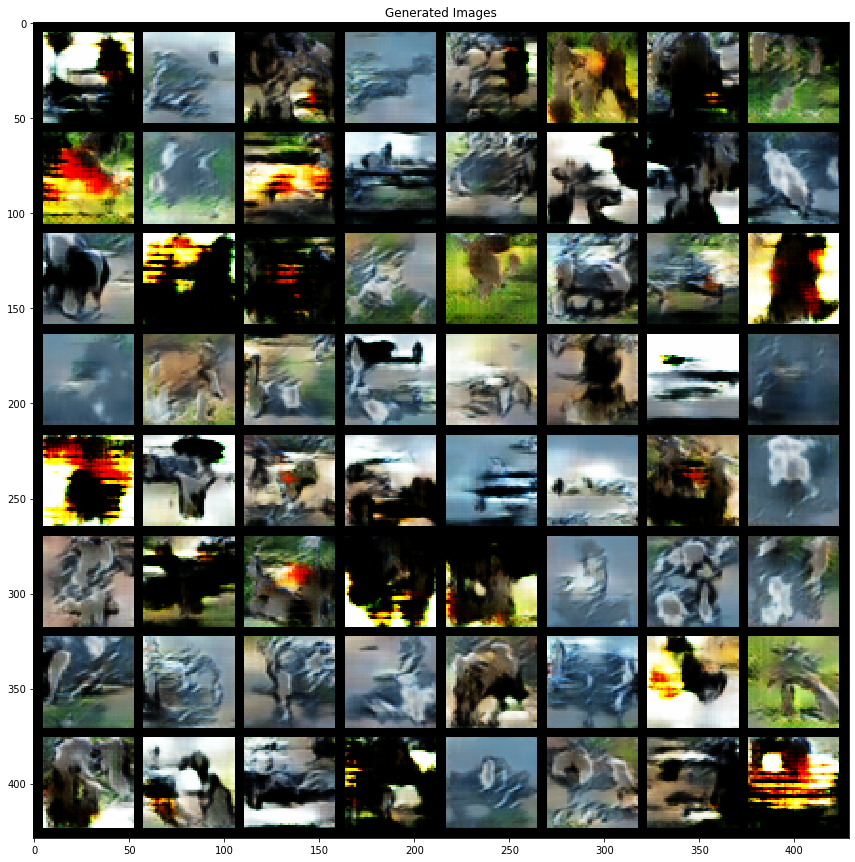

In [11]:
#plot_loss(G_losses, D_losses, "./figures/convnet_loss.svg")

path = pathlib.Path("./best_models_convnet/")
model_paths = list(path.glob('*.pt'))
best_idx = np.argsort(np.array([int(str(item).split(".")[0].split("_")[-1]) for item in model_paths]))[-1]
model_path = model_paths[best_idx]

model = load_model(model_path)
is_mean, is_std, fid = eval_model(model, dataroot, 10240, device, "./generated_samples_convnet")


# SphereGAN ResNet Training

In [8]:
manual_seed = 101
random.seed(manual_seed)

torch.manual_seed(manual_seed)
genResnet = GeneratorResNet().to(device)

torch.manual_seed(manual_seed)
disResnet = DiscriminatorResNet().to(device)

torch.manual_seed(manual_seed)
genResnet.apply(weights_init)

torch.manual_seed(manual_seed)
disResnet.apply(weights_init)


DiscriminatorResNet(
  (conv1): conv3x3(
    (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (rb1): ResidualBlockDownSample(
    (avg_pool1): AdaptiveAvgPool2d(output_size=(24, 24))
    (conv_shortcut): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.2)
    (relu2): LeakyReLU(negative_slope=0.2)
    (ln1): LayerNorm(torch.Size([256, 48, 48]), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm(torch.Size([256, 24, 24]), eps=1e-05, elementwise_affine=True)
    (conv_1): conv3x3(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (conv_2): conv3x3(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (avg_pool2): AdaptiveAvgPool2d(output_size=(24, 24))
  )
  (rb2): ResidualBlockDownSample(
    (avg_pool1): AdaptiveAvgPool2d(output_size=(12, 12))
    (conv_shortcut): Conv2d(256, 256, kernel_size

In [9]:
optimizerGenResnet = optim.Adam(genResnet.parameters(), lr=lr, betas=(beta1, beta2))
optimizerDiscResnet = optim.Adam(disResnet.parameters(), lr=lr, betas=(beta1, beta2))

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
dataloader_resnet = get_stl10_dataloader(dataroot, batch_size, workers, image_size)

best_is_resnet = [0,0]

img_list_resnet = []
G_losses_resnet = []
D_losses_resnet = []
iters_resnet = 0
moments_resnet = 3

Files already downloaded and verified


In [10]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_resnet, 0):

        ############################
        # (1) Update Discriminator
        ###########################
        disResnet.zero_grad()
        label = torch.full((batch_size,1), real_label, device=device)
        
        # Forward pass real batch through D
        output = disResnet(data[0].to(device))
        
        # Calculate loss on all-real batch
        error_disc_real = total_moment_distance(output, label, moments_resnet, device)
        
        # Calculate gradients for D in backward pass
        error_disc_real.backward()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, 128, device=device)
        
        # Generate fake image batch with G
        fake = genResnet(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = disResnet(fake.detach())
        
        # Calculate D's loss on the all-fake batch
        error_disc_fake = total_moment_distance(output, label, moments_resnet, device)
        
        
        # Calculate the gradients for this batch
        error_disc_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        error_disc = error_disc_real + error_disc_fake
        #error_disc.backward()
        
        # Update D
        optimizerDiscResnet.step()

        ############################
        # (2) Update Generator
        ###########################
        genResnet.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disResnet(fake)
        
        # Calculate G's loss based on this output
        error_gen = total_moment_distance(output, label, moments_resnet, device)
        
        # Calculate gradients for G
        error_gen.backward()
        
        # Update G
        optimizerGenResnet.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader_resnet),
                     error_disc.item(), error_gen.item()))

        G_losses_resnet.append(error_gen.item())
        D_losses_resnet.append(error_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters_resnet % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_resnet)-1)):
            
            with torch.no_grad():
                fake_images = genResnet(fixed_noise.to(device)).detach().cpu()
            img_list_resnet.append(vutils.make_grid(fake_images, padding=2, normalize=True))
            
            genResnet = genResnet.cpu()
            disResnet = disResnet.cpu()
            inception_net = inception_net.to(device)
   
            
            _is = inception_score_val(fake_images, inception_net, device)
            print("Iter:", iters_resnet,  "Inception Score:", _is, "\n")
            if (_is[0] > 2.0 and best_is_resnet[0] == 0) or (_is[0] > best_is_resnet[0] and best_is_resnet[0] != 0):
                best_is_resnet = _is
                torch.save({
                    'epoch': epoch,
                    'gen_state_dict': genResnet.state_dict(),
                    'gen_optimizer_state_dict': optimizerGenResnet.state_dict(),
                    'dis_state_dict': disResnet.state_dict(),
                    'dis_optimizer_state_dict': optimizerDiscResnet.state_dict(),
                    'img_list': img_list_resnet,
                    'inception_score': best_is_resnet
                    }, './checkpoints/resnet_state_dict_{}'.format(epoch))

                save_model(genResnet, "./best_models_resnet/model_{}.pt".format(epoch))
            
            inception_net = inception_net.cpu()
            genResnet = genResnet.to(device)
            disResnet = disResnet.to(device)
         
             
            plt.clf()
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list_resnet[-1],(1,2,0)))
            plt.savefig("./figures/progress/resnet_fake_iter_{}.svg".format(iters_resnet))
            plt.clf()


        iters_resnet += 1

[0/1300][0/78]	Loss_D: 0.0003	Loss_G: 0.0049
Iter: 0 Inception Score: (1.3555575943015215, 0.1777094430280576) 

[0/1300][50/78]	Loss_D: -0.0003	Loss_G: 0.0026
[1/1300][0/78]	Loss_D: 0.0007	Loss_G: 0.0022
[1/1300][50/78]	Loss_D: -0.0003	Loss_G: 0.0047
[2/1300][0/78]	Loss_D: -0.0006	Loss_G: 0.0074
[2/1300][50/78]	Loss_D: -0.0019	Loss_G: 0.0166
[3/1300][0/78]	Loss_D: -0.0005	Loss_G: 0.0089
[3/1300][50/78]	Loss_D: -0.0012	Loss_G: 0.0123
[4/1300][0/78]	Loss_D: -0.0048	Loss_G: 0.0127
[4/1300][50/78]	Loss_D: -0.0001	Loss_G: 0.0010
[5/1300][0/78]	Loss_D: -0.0006	Loss_G: 0.0127
[5/1300][50/78]	Loss_D: 0.0001	Loss_G: 0.0008
[6/1300][0/78]	Loss_D: -0.0000	Loss_G: 0.0007
Iter: 500 Inception Score: (1.4191193857328497, 0.20313576126488295) 

[6/1300][50/78]	Loss_D: -0.0000	Loss_G: 0.0013
[7/1300][0/78]	Loss_D: -0.0038	Loss_G: 0.0100
[7/1300][50/78]	Loss_D: -0.0003	Loss_G: 0.0032
[8/1300][0/78]	Loss_D: -0.0002	Loss_G: 0.0019
[8/1300][50/78]	Loss_D: -0.0000	Loss_G: 0.0012
[9/1300][0/78]	Loss_D: -0.0

[77/1300][0/78]	Loss_D: -0.1114	Loss_G: 0.1795
[77/1300][50/78]	Loss_D: -0.0631	Loss_G: 0.2009
[78/1300][0/78]	Loss_D: -0.0450	Loss_G: 0.1202
[78/1300][50/78]	Loss_D: -0.0601	Loss_G: 0.1706
[79/1300][0/78]	Loss_D: -0.1096	Loss_G: 0.2727
[79/1300][50/78]	Loss_D: -0.1036	Loss_G: 0.5247
[80/1300][0/78]	Loss_D: -0.0911	Loss_G: 0.1813
[80/1300][50/78]	Loss_D: -0.0708	Loss_G: 0.1457
[81/1300][0/78]	Loss_D: -0.0892	Loss_G: 0.4999
[81/1300][50/78]	Loss_D: -0.0619	Loss_G: 0.1582
[82/1300][0/78]	Loss_D: -0.0824	Loss_G: 0.3902
[82/1300][50/78]	Loss_D: -0.0201	Loss_G: 0.1998
[83/1300][0/78]	Loss_D: -0.0533	Loss_G: 0.1432
Iter: 6500 Inception Score: (1.9037219441134994, 0.2541589323825113) 

[83/1300][50/78]	Loss_D: -0.0670	Loss_G: 0.3107
[84/1300][0/78]	Loss_D: -0.0867	Loss_G: 0.3152
[84/1300][50/78]	Loss_D: -0.1517	Loss_G: 0.2711
[85/1300][0/78]	Loss_D: -0.0734	Loss_G: 0.4172
[85/1300][50/78]	Loss_D: -0.0896	Loss_G: 0.4702
[86/1300][0/78]	Loss_D: -0.0180	Loss_G: 0.1109
[86/1300][50/78]	Loss_D: -0

Iter: 12000 Inception Score: (1.9168054933923653, 0.25363925378850155) 

[154/1300][0/78]	Loss_D: -0.3068	Loss_G: 2.1873
[154/1300][50/78]	Loss_D: -0.1696	Loss_G: 0.4402
[155/1300][0/78]	Loss_D: -0.2345	Loss_G: 0.6399
[155/1300][50/78]	Loss_D: -0.2207	Loss_G: 0.3870
[156/1300][0/78]	Loss_D: -0.7953	Loss_G: 0.1403
[156/1300][50/78]	Loss_D: -0.7922	Loss_G: 1.3547
[157/1300][0/78]	Loss_D: -0.1871	Loss_G: 0.4519
[157/1300][50/78]	Loss_D: -0.1196	Loss_G: 0.4973
[158/1300][0/78]	Loss_D: -0.2616	Loss_G: 0.7859
[158/1300][50/78]	Loss_D: -0.2149	Loss_G: 0.5891
[159/1300][0/78]	Loss_D: -0.6582	Loss_G: 0.6930
[159/1300][50/78]	Loss_D: -0.1520	Loss_G: 1.2510
[160/1300][0/78]	Loss_D: -0.1324	Loss_G: 1.0962
Iter: 12500 Inception Score: (2.0787544029946607, 0.33633886073219393) 

[160/1300][50/78]	Loss_D: -1.5535	Loss_G: 0.1842
[161/1300][0/78]	Loss_D: -0.5605	Loss_G: 3.1385
[161/1300][50/78]	Loss_D: -0.3765	Loss_G: 2.3776
[162/1300][0/78]	Loss_D: -0.2933	Loss_G: 0.9587
[162/1300][50/78]	Loss_D: -1.2

[230/1300][0/78]	Loss_D: -1.7276	Loss_G: 6.4185
[230/1300][50/78]	Loss_D: -1.7034	Loss_G: 6.0406
Iter: 18000 Inception Score: (2.0718325146547234, 0.4371783555218287) 

[231/1300][0/78]	Loss_D: -0.7376	Loss_G: 2.1178
[231/1300][50/78]	Loss_D: -3.9448	Loss_G: 2.9642
[232/1300][0/78]	Loss_D: -2.7159	Loss_G: 6.1905
[232/1300][50/78]	Loss_D: -2.6100	Loss_G: 2.1124
[233/1300][0/78]	Loss_D: -0.4744	Loss_G: 1.0775
[233/1300][50/78]	Loss_D: -0.3134	Loss_G: 2.2346
[234/1300][0/78]	Loss_D: -1.4037	Loss_G: 6.6099
[234/1300][50/78]	Loss_D: -1.3951	Loss_G: 11.0223
[235/1300][0/78]	Loss_D: -1.5106	Loss_G: 4.0656
[235/1300][50/78]	Loss_D: -3.9398	Loss_G: 2.5761
[236/1300][0/78]	Loss_D: -1.7210	Loss_G: 4.9479
[236/1300][50/78]	Loss_D: -2.2705	Loss_G: 10.3622
[237/1300][0/78]	Loss_D: -1.3110	Loss_G: 4.0206
Iter: 18500 Inception Score: (2.181226385906996, 0.20517470501752297) 

[237/1300][50/78]	Loss_D: -1.5955	Loss_G: 7.9249
[238/1300][0/78]	Loss_D: -2.5506	Loss_G: 5.5774
[238/1300][50/78]	Loss_D: -2.0

[305/1300][0/78]	Loss_D: -18.1876	Loss_G: 11.8326
[305/1300][50/78]	Loss_D: -4.5050	Loss_G: 9.7859
[306/1300][0/78]	Loss_D: -20.5146	Loss_G: 7.0693
[306/1300][50/78]	Loss_D: -16.3935	Loss_G: 10.4236
[307/1300][0/78]	Loss_D: -14.0923	Loss_G: 5.8686
[307/1300][50/78]	Loss_D: -19.5924	Loss_G: 10.9933
Iter: 24000 Inception Score: (1.9402986771428175, 0.18364500840459172) 

[308/1300][0/78]	Loss_D: -18.2444	Loss_G: 11.3835
[308/1300][50/78]	Loss_D: -16.0440	Loss_G: 15.4159
[309/1300][0/78]	Loss_D: -15.0939	Loss_G: 8.9391
[309/1300][50/78]	Loss_D: -12.2042	Loss_G: 27.5737
[310/1300][0/78]	Loss_D: -8.5764	Loss_G: 29.7805
[310/1300][50/78]	Loss_D: -17.9379	Loss_G: 10.7116
[311/1300][0/78]	Loss_D: -23.3589	Loss_G: 8.2801
[311/1300][50/78]	Loss_D: -7.9228	Loss_G: 25.8414
[312/1300][0/78]	Loss_D: -24.1035	Loss_G: 8.4677
[312/1300][50/78]	Loss_D: -25.0802	Loss_G: 10.2022
[313/1300][0/78]	Loss_D: -21.6234	Loss_G: 4.4016
[313/1300][50/78]	Loss_D: -15.9820	Loss_G: 13.3673
[314/1300][0/78]	Loss_D: -10

[378/1300][50/78]	Loss_D: -34.0034	Loss_G: 14.7943
[379/1300][0/78]	Loss_D: -12.8934	Loss_G: 22.3103
[379/1300][50/78]	Loss_D: -19.5285	Loss_G: 38.7698
[380/1300][0/78]	Loss_D: -0.5800	Loss_G: 32.4126
[380/1300][50/78]	Loss_D: -18.2636	Loss_G: 34.4742
[381/1300][0/78]	Loss_D: -16.2191	Loss_G: 33.4727
[381/1300][50/78]	Loss_D: -0.0591	Loss_G: 0.6568
[382/1300][0/78]	Loss_D: -15.0624	Loss_G: 30.5374
[382/1300][50/78]	Loss_D: -18.7642	Loss_G: 33.2682
[383/1300][0/78]	Loss_D: -21.7431	Loss_G: 36.2243
[383/1300][50/78]	Loss_D: -19.9974	Loss_G: 38.1405
[384/1300][0/78]	Loss_D: -33.1032	Loss_G: 16.4369
Iter: 30000 Inception Score: (1.2107374426448678, 0.06321780670076076) 

[384/1300][50/78]	Loss_D: -7.3295	Loss_G: 28.5132
[385/1300][0/78]	Loss_D: -12.4579	Loss_G: 25.9772
[385/1300][50/78]	Loss_D: -23.2136	Loss_G: 27.2193
[386/1300][0/78]	Loss_D: -17.5398	Loss_G: 33.3377
[386/1300][50/78]	Loss_D: -16.6038	Loss_G: 33.0021
[387/1300][0/78]	Loss_D: -23.0790	Loss_G: 32.2825
[387/1300][50/78]	Loss

[452/1300][0/78]	Loss_D: -37.2118	Loss_G: 26.2335
[452/1300][50/78]	Loss_D: -38.5658	Loss_G: 24.4917
[453/1300][0/78]	Loss_D: -35.1250	Loss_G: 24.9608
[453/1300][50/78]	Loss_D: -37.6759	Loss_G: 25.7447
[454/1300][0/78]	Loss_D: -38.5152	Loss_G: 26.5501
[454/1300][50/78]	Loss_D: -36.9401	Loss_G: 24.3264
[455/1300][0/78]	Loss_D: -40.5992	Loss_G: 23.6886
Iter: 35500 Inception Score: (1.0456795129765197, 0.03878570148212326) 

[455/1300][50/78]	Loss_D: -35.7458	Loss_G: 25.6060
[456/1300][0/78]	Loss_D: -38.3104	Loss_G: 23.7309
[456/1300][50/78]	Loss_D: -38.4477	Loss_G: 25.0082
[457/1300][0/78]	Loss_D: -38.5200	Loss_G: 28.0032
[457/1300][50/78]	Loss_D: -37.0611	Loss_G: 26.0302
[458/1300][0/78]	Loss_D: -24.1736	Loss_G: 39.6945
[458/1300][50/78]	Loss_D: -23.3216	Loss_G: 38.6463
[459/1300][0/78]	Loss_D: -27.9671	Loss_G: 36.8138
[459/1300][50/78]	Loss_D: -24.6697	Loss_G: 37.3448
[460/1300][0/78]	Loss_D: -27.0277	Loss_G: 38.1647
[460/1300][50/78]	Loss_D: -24.8092	Loss_G: 39.0325
[461/1300][0/78]	L

[525/1300][0/78]	Loss_D: -37.8876	Loss_G: 24.6517
[525/1300][50/78]	Loss_D: -37.3437	Loss_G: 28.5038
Iter: 41000 Inception Score: (1.0000155492955654, 3.711668596105587e-06) 

[526/1300][0/78]	Loss_D: -32.3094	Loss_G: 19.4619
[526/1300][50/78]	Loss_D: -40.4397	Loss_G: 28.0214
[527/1300][0/78]	Loss_D: -41.7160	Loss_G: 27.2220
[527/1300][50/78]	Loss_D: -37.9146	Loss_G: 28.3446
[528/1300][0/78]	Loss_D: -40.6128	Loss_G: 28.9301
[528/1300][50/78]	Loss_D: -40.3603	Loss_G: 31.1257
[529/1300][0/78]	Loss_D: -38.9363	Loss_G: 28.2649
[529/1300][50/78]	Loss_D: -36.6497	Loss_G: 29.3153
[530/1300][0/78]	Loss_D: -40.5386	Loss_G: 30.3955
[530/1300][50/78]	Loss_D: -41.3192	Loss_G: 28.6191
[531/1300][0/78]	Loss_D: -39.4354	Loss_G: 29.3152
[531/1300][50/78]	Loss_D: -41.3195	Loss_G: 27.2717
[532/1300][0/78]	Loss_D: -40.9010	Loss_G: 27.9351
Iter: 41500 Inception Score: (1.00001168274612, 3.3253205956865774e-06) 

[532/1300][50/78]	Loss_D: -39.3510	Loss_G: 29.9391
[533/1300][0/78]	Loss_D: -39.0774	Loss_G: 2

[597/1300][50/78]	Loss_D: -41.9975	Loss_G: 31.0961
[598/1300][0/78]	Loss_D: -40.7495	Loss_G: 31.6762
[598/1300][50/78]	Loss_D: -38.8621	Loss_G: 30.9945
[599/1300][0/78]	Loss_D: -37.8363	Loss_G: 27.5874
[599/1300][50/78]	Loss_D: -33.0777	Loss_G: 39.6549
[600/1300][0/78]	Loss_D: -31.7151	Loss_G: 40.9116
[600/1300][50/78]	Loss_D: -32.3328	Loss_G: 36.1312
[601/1300][0/78]	Loss_D: -31.0554	Loss_G: 41.4057
[601/1300][50/78]	Loss_D: -31.8569	Loss_G: 40.0327
[602/1300][0/78]	Loss_D: -40.6109	Loss_G: 31.1251
Iter: 47000 Inception Score: (1.0000091057825105, 2.076653171677056e-06) 

[602/1300][50/78]	Loss_D: -39.3914	Loss_G: 33.8590
[603/1300][0/78]	Loss_D: -41.4499	Loss_G: 32.6629
[603/1300][50/78]	Loss_D: -41.2110	Loss_G: 31.2471
[604/1300][0/78]	Loss_D: -40.0196	Loss_G: 32.2074
[604/1300][50/78]	Loss_D: -40.8538	Loss_G: 31.2318
[605/1300][0/78]	Loss_D: -41.3619	Loss_G: 31.0584
[605/1300][50/78]	Loss_D: -41.0751	Loss_G: 30.6414
[606/1300][0/78]	Loss_D: -39.6553	Loss_G: 32.5209
[606/1300][50/78

[670/1300][50/78]	Loss_D: -41.3877	Loss_G: 33.5638
[671/1300][0/78]	Loss_D: -40.8396	Loss_G: 33.0726
[671/1300][50/78]	Loss_D: -32.5532	Loss_G: 42.0212
[672/1300][0/78]	Loss_D: -36.2514	Loss_G: 37.7895
[672/1300][50/78]	Loss_D: -31.4054	Loss_G: 39.2035
[673/1300][0/78]	Loss_D: -32.0531	Loss_G: 40.6510
Iter: 52500 Inception Score: (1.0000163491714396, 7.550788874258589e-06) 

[673/1300][50/78]	Loss_D: -35.2388	Loss_G: 38.9165
[674/1300][0/78]	Loss_D: -32.7505	Loss_G: 40.1380
[674/1300][50/78]	Loss_D: -39.2858	Loss_G: 33.8070
[675/1300][0/78]	Loss_D: -34.1708	Loss_G: 41.2603
[675/1300][50/78]	Loss_D: -33.4860	Loss_G: 41.2126
[676/1300][0/78]	Loss_D: -35.1158	Loss_G: 38.9291
[676/1300][50/78]	Loss_D: -33.0661	Loss_G: 41.4645
[677/1300][0/78]	Loss_D: -35.0099	Loss_G: 39.8057
[677/1300][50/78]	Loss_D: -33.9910	Loss_G: 40.9117
[678/1300][0/78]	Loss_D: -34.0477	Loss_G: 42.0917
[678/1300][50/78]	Loss_D: -33.7443	Loss_G: 41.3930
[679/1300][0/78]	Loss_D: -34.0503	Loss_G: 37.2217
Iter: 53000 Ince

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

Generating images...
Saving real images...
Files already downloaded and verified
Calculating IS...
0 / 10240
1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
Calculating FID...
0 / 10240


/home/ismail/p3-dl-venv/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
0 / 10240
1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
IS: 4.932433068583619 0.09854059859634723
FID: 89.15078199532547


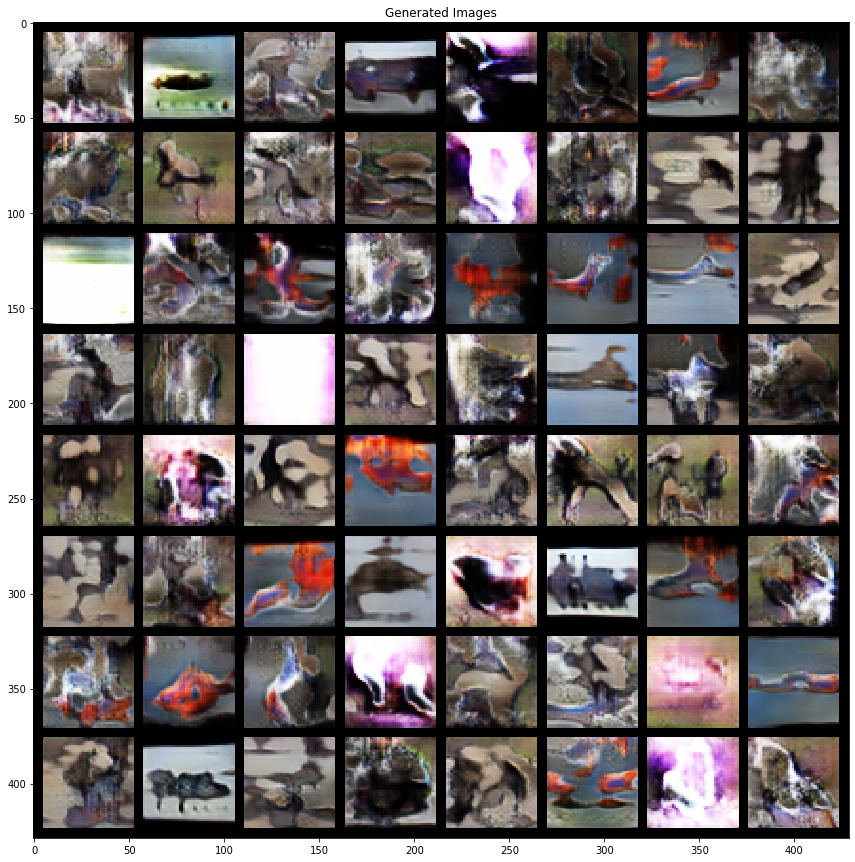

In [10]:
plot_loss(G_losses_resnet, D_losses_resnet, "./figures/resnet_loss.svg")

path = pathlib.Path("./best_models_resnet/")
model_paths = (list(path.glob('*.pt')))
best_idx = np.argsort(np.array([int(str(item).split(".")[0].split("_")[-1]) for item in model_paths]))[-1]
model_path = model_paths[best_idx]

model = load_model(model_path)
is_mean, is_std, fid = eval_model(model, dataroot, 10240, device, "./generated_samples_resnet")
